In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def DegToTurns(deg):
    ratio = 45/1000 # degrees / turns
    return deg / ratio

def TurnsToDeg(turns):
    ratio = 45/1000 # degrees / turns
    return turns * ratio

In [3]:
TurnsToDeg(300)

13.5

In [4]:
def WriteFile(fileName, data):
 
    data = np.transpose(data)
    
    with open(fileName, "w") as f:
        np.savetxt(fileName, data)

def LoadFile(path):
    data = np.array(np.loadtxt(path))
    return data

In [5]:
def ExternalToInternalAngle(external, n=1.53, A=45):
    # input external angle in degrees, refractive index, prism angle
    # returns internal angle in degrees
    radPerDeg = np.pi / 180
    
    external *= radPerDeg
    A *= radPerDeg
    
    return (np.arcsin(np.sin(external - A) / n) + A) * 180 / np.pi

In [6]:
def ConvertNToDegrees(data, offset, mode="external"):
    # returns the same set of data with the x column changing to degrees
    NValues = data[:,0]
    degrees = list()
    
    degreesPerN = 45/1000
    
    i=0
    for N in NValues:
        
        if mode == "internal":
            degrees.append(ExternalToInternalAngle(N * degreesPerN + offset))
        if mode == "external":
            degrees.append(N * degreesPerN + offset)
            
        i+=1
        
    data[:,0] = degrees
    
    return data

In [7]:
def NormaliseData(data):
    maxVal = 0
    for el in data[:,1]: # Loop through all data elements
        if el > maxVal:
            maxVal = el

    data[:,1] = [el / maxVal for el in data[:,1]]
    return data

In [42]:
def PlotFile(path, angleMode = "internal", offset=30.5, normalise=True, errors=True, label="", errLabel=True, showPlot=True, returnData=False,\
    errColour="red", lineColour="blue", grid=True):
    if type(path) == str: data = LoadFile(path)
    if type(path) == np.ndarray : data = path

    if normalise:
        data = NormaliseData(data)
        if showPlot: plt.ylabel("Normalised Intensity")
    else:
        if showPlot: plt.ylabel("Intensity")

    if angleMode == "external":    
        data = ConvertNToDegrees(data, offset, mode="external")
        
    if angleMode == "internal":
        data = ConvertNToDegrees(data, offset, mode="internal")

    if showPlot:  
        plt.xlabel(f"{angleMode.upper()} Angle (Degrees)")

        plt.plot(data[:,0], data[:,1], label=label, zorder=1, color=lineColour)

        if errors and errLabel: plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt="", zorder=0, color=errColour, label=label+" Err")
        if errors and not errLabel: plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt="", zorder=0, color=errColour)
        
        if grid: 
            plt.grid(b=True, which='major', color='grey', linestyle='-')
            plt.grid(b=True, which='minor', color='grey', linestyle='--')
        if label != "":
            plt.legend()

    if returnData:       
        return data

In [43]:
def PlotAverageFiles(pathList, angleMode="external", offset=0, normalise=True, errors=True):
    
    dataList = [np.array(np.loadtxt(file)) for file in pathList]
    
    dataAvg = np.zeros(np.shape(dataList[0]))
    dataAvg[:,0] = dataList[0][:,0]

    voltagesOfEachData=list()
    for data in dataList:
        
        voltagesOfEachData.append(data[:,1])

        k=0
        stds = list()
        voltagesOfEachData = np.array(voltagesOfEachData)
        while k < len(voltagesOfEachData[:,0]):
            V = list()
            for voltageList in voltagesOfEachData:
                V.append(voltageList[k])
            dataAvg[:,1][k] = np.mean(V)
            stds.append(np.std(V))
            k+=1


    # Weighting uncertainties based on distance from mean value
    for data in dataList:
        i=0
        weights=list()
        for voltage in data[:,1]:
            w = (1 - abs(dataAvg[:,1][i] - voltage))
            if w < 0 : w = 0

            weights.append(w*voltage)
            i+=1
        
        j=0
        for uncertainty in data[:,2]:
            dataAvg[:,2][j] += data[:,2][j]*weights[j]
            j+=1

        print(stds)
        dataAvg[:,2] = dataAvg[:,2]*dataAvg[:,1] / (len(dataList) * stds[j])
    
    PlotFile(dataAvg, angleMode=angleMode, offset=offset, normalise=normalise, errors=errors)

## Wavelength Dependence

/tmp/ipykernel_17402/3285962222.py:27: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_17402/3285962222.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='--')


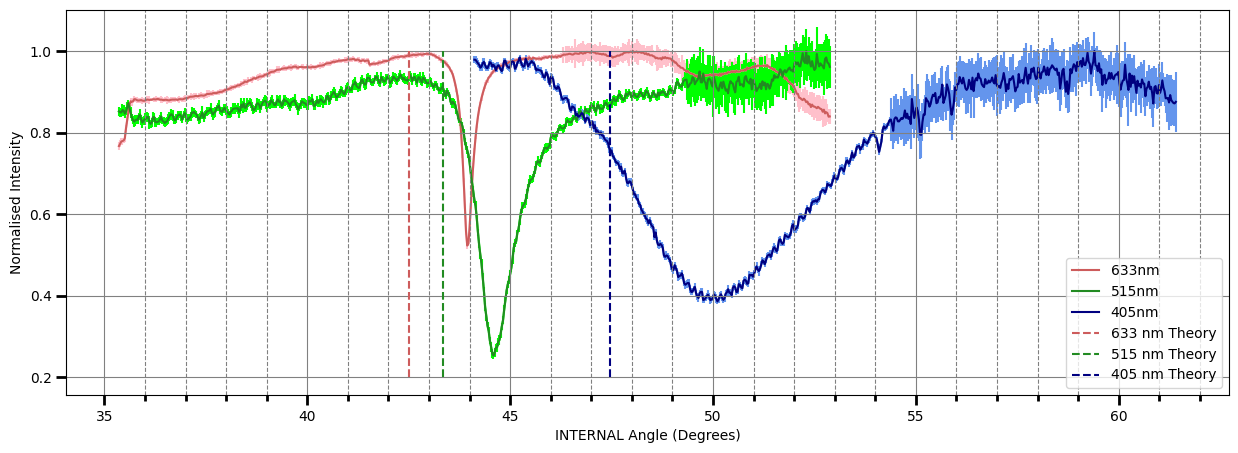

In [47]:
PlotFile("13nm/red/red01.txt", lineColour="indianred", errColour="pink", label="633nm", errLabel=False, offset=30.15)
PlotFile("13nm/green/green01.txt", lineColour="forestgreen", errColour="lime", label="515nm", errLabel=False, offset=30.15)
PlotFile("13nm/blue/blue01.txt", lineColour="navy", errColour="cornflowerblue", label="405nm", errLabel=False, offset=43.65)
plt.vlines(42.5, 0.2, 1.0, colors="indianred", linestyles="dashed",label="633 nm Theory")
plt.vlines(43.35, 0.2, 1.0, colors="forestgreen", linestyles="dashed",label="515 nm Theory")
plt.vlines(47.45, 0.2, 1.0, colors="navy", linestyles="dashed",label="405 nm Theory")
plt.legend(loc="lower right")

from matplotlib import ticker

fig = plt.gcf()
fig.set_size_inches(15, 5)

ax = fig.get_axes()[0]

ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=4, color='black')

## Thickness Dependence

### Red

Text(0.5, 1.0, 'Red Laser: 633 nm')

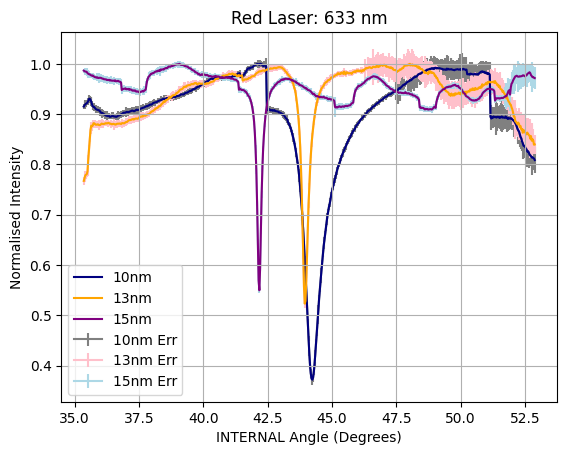

In [16]:
PlotFile("10nm/red/red05.txt", lineColour="navy", errColour="grey", label="10nm", offset=30.15)
PlotFile("13nm/red/red01.txt", lineColour="orange", errColour="pink", label="13nm", offset=30.15)
PlotFile("15nm/red/red02.txt", lineColour="purple", errColour="lightblue", label="15nm", offset=30.15)
plt.title("Red Laser: 633 nm")

### Green

Text(0.5, 1.0, 'Green Laser: 515 nm')

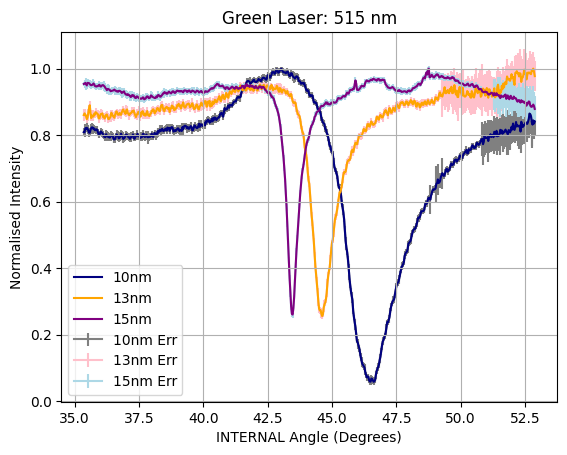

In [17]:
PlotFile("10nm/green/green03.txt", lineColour="navy", errColour="grey", label="10nm", offset=30.15)
PlotFile("13nm/green/green03.txt", lineColour="orange", errColour="pink", label="13nm", offset=30.15)
PlotFile("15nm/green/green02.txt", lineColour="purple", errColour="lightblue", label="15nm", offset=30.15)
plt.title("Green Laser: 515 nm")

### Blue

Text(0.5, 1.0, 'Blue Laser: 405 nm')

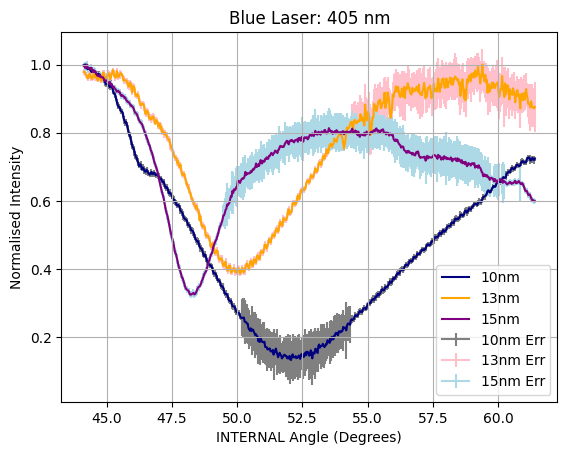

In [18]:
PlotFile("10nm/blue/blue01.txt", lineColour="navy", errColour="grey", label="10nm", offset=43.65)
PlotFile("13nm/blue/blue01.txt", lineColour="orange", errColour="pink", label="13nm", offset=43.65)
PlotFile("15nm/blue/blue01.txt", lineColour="purple", errColour="lightblue", label="15nm", offset=43.65)
plt.title("Blue Laser: 405 nm")

# Period of Oscillations

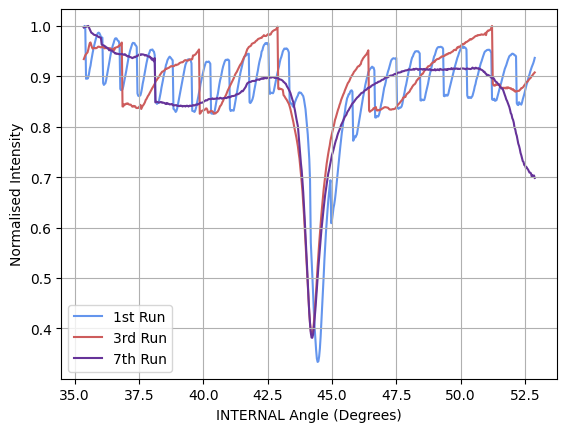

In [86]:
PlotFile("10nm/red/red01.txt", angleMode="internal", offset=30.15, errors=False, lineColour="cornflowerblue", label="1st Run")
PlotFile("10nm/red/red03.txt", angleMode="internal", offset=30.15, errors=False, lineColour="indianred", label="3rd Run")
PlotFile("10nm/red/red07.txt", angleMode="internal", offset=30.15, errors=False, lineColour="rebeccapurple", label="7th Run")
#plt.grid()

In [19]:
from scipy import signal # Sawtooth wave function
from scipy.optimize import curve_fit
from scipy.odr import *

In [20]:
def Sin(t, amplitude, periodFactor, phase, height):
    return amplitude * np.sin(periodFactor *t + phase) + height

In [23]:
def FindPeriod(filePath, fitFunction, guessPars, showPlot=False, plotRange=[30.5,37], title=""):
    data = PlotFile(filePath, errors=False, showPlot=False, returnData=True)
    
    if data[:,0][0] == 43.955:
        data = np.flipud(data)
    data = np.delete(data, [np.arange(150,300,1)], 0)

    pars, cov = curve_fit(fitFunction, data[:,0], data[:,1], guessPars)

    t = np.linspace(plotRange[0], plotRange[1], 1000)
    
    period = 2* np.pi / pars[1]

    if showPlot:
        plt.scatter(data[:,0], data[:,1], label="Data", color="indianred", zorder=1)
        plt.plot(t, Sin(t, pars[0], pars[1], pars[2], pars[3]), label=f"Period of Oscillations: {period:0.2f}", color="cornflowerblue", zorder=0)
        plt.title(title)
        #plt.hlines(pars[3], plotRange[0], plotRange[0]+period, color = "orange", label=f"Period {period:0.2f}$^\circ$")
        plt.xlabel("Angle (degrees)")
        plt.ylabel("Normalised Intensity")
        plt.legend()
        plt.grid()

    uPeriod = np.sqrt(cov[1][1])

    return [period, uPeriod]

[0.59588898457004, 1.446982890607356, 1.7392199032091813, 2.96541665996552, 2.774992624200253]
[0.593569427664591, 0.1501589048327938, 0.22853668993065682, 0.17467330662056454, 0.024966878914726393]


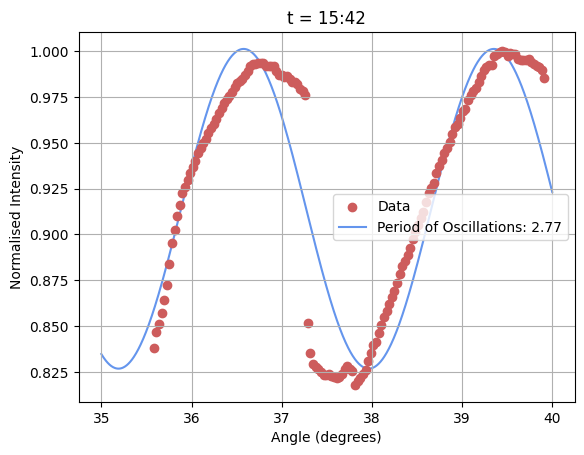

In [33]:
periods = list()

timeFiles = glob("Time/dep*.txt")
timeFiles = [str(el) for el in np.sort(timeFiles)]

p0 = FindPeriod(timeFiles[0], Sin, [0.1, 10, 0, 0.9], showPlot=False, title="t = 15:26")
p1 = FindPeriod(timeFiles[1], Sin, [0.1, 5, -1, 0.9], showPlot=False, title="t = 15:30")
p2 = FindPeriod(timeFiles[2], Sin, [0.1, 4, -1, 0.9], showPlot=False, title="t = 15:34")
p3 = FindPeriod(timeFiles[3], Sin, [0.1, 3, -1, 0.9], showPlot=False, title="t = 15:38")
p4 = FindPeriod(timeFiles[4], Sin, [0.1, 3, -1, 0.9], showPlot=True, title="t = 15:42", plotRange=[35,40])
p5 = FindPeriod(timeFiles[5], Sin, [0.1, 1/8, -1, 0.9], showPlot=True, title="t = 15:46")
periods = [p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]]
uncertainties = [p0[1], p1[1], p2[1], p3[1], p4[1], p5[1]]
print(periods)
print(uncertainties)

[0.0099833  0.02945659 0.61382912]


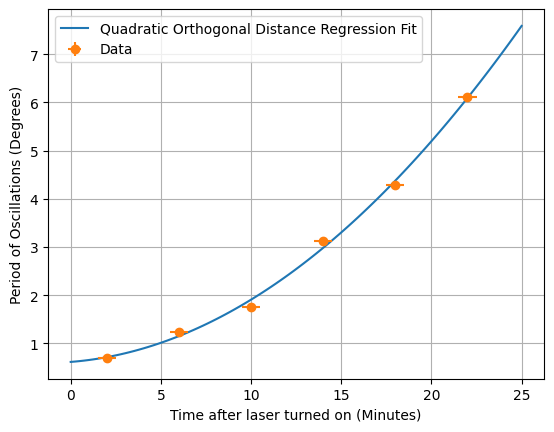

In [18]:
times = [2, 6, 10, 14, 18, 22]
uTime = 0.5 # minutes

def QuadFunc(p, x):
    A, B, C = p
    return A*x**2 + B*x + C

quadModel = Model(QuadFunc)

data = RealData(times, periods)

odr = ODR(data, quadModel, beta0=[1, 1, 1])

out = odr.run()
print(out.beta)
t = np.linspace(0, 25, 100)

plt.plot(t, QuadFunc(out.beta, t), label="Quadratic Orthogonal Distance Regression Fit")

plt.errorbar(times, periods, xerr=uTime, yerr=uncertainties, fmt="o", label="Data")
plt.xlabel("Time after laser turned on (Minutes)")
plt.ylabel("Period of Oscillations (Degrees)")
plt.grid()
plt.legend()

Text(0.5, 0, 'Steps')

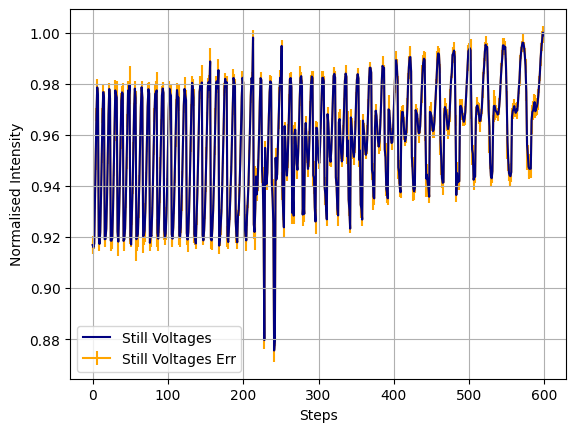

In [44]:
stilldata01 = LoadFile("13nm/still/still01.txt")

#plt.plot(stilldata01[:,0], stilldata01[:,1], zorder=1)
#plt.errorbar(stilldata01[:,0], stilldata01[:,1], yerr=stilldata01[:,2], fmt="", zorder=0)
PlotFile(stilldata01, lineColour="navy", errColour="orange", label="Still Voltages", angleMode="None")
plt.xlabel("Steps")